In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_raw = pd.read_csv('/content/sample_data/diabetic_data.csv');
df_raw.shape

(101766, 50)

In [3]:
df_raw.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

#Cleaning the dataset

In [5]:
df = df_raw.copy()

#Create binary target variable for 'readmitted'
df['readmitted_less_than_30_days'] = (df['readmitted'] == '< 30').astype(int)
df.drop('readmitted', axis=1, inplace=True)

#Removing identifier columns not useful for modeling
df.drop('encounter_id', axis =1, inplace= True)

#Removing duplicate patients
initial_rows = df.shape[0]
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')
print(f'Removed {initial_rows - df.shape[0]} duplicate rows')

Removed 30248 duplicate rows


In [6]:
#Dropping columns with a high percentage of missing values(>40%)
missing_percentage = (df.isnull()).sum() / len(df)
cols_to_drop = missing_percentage[missing_percentage > 0.4].index
df = df.drop(cols_to_drop, axis=1)
print(f'Dropped {list(cols_to_drop)} columns with >40% missing values')

Dropped ['max_glu_serum', 'A1Cresult'] columns with >40% missing values


In [14]:
#Cleaning gender column to remove 'Unknown/Invalid'
if 'gender' in df.columns and 'Unknown/Invalid' in df['gender'].unique():
  df = df[df['gender'] != 'Unknown/Invalid']
print(df.shape)
print(df.head())

(71515, 47)
   patient_nbr             race  gender      age weight  admission_type_id  \
0      8222157        Caucasian  Female   [0-10)      ?                  6   
1     55629189        Caucasian  Female  [10-20)      ?                  1   
2     86047875  AfricanAmerican  Female  [20-30)      ?                  1   
3     82442376        Caucasian    Male  [30-40)      ?                  1   
4     42519267        Caucasian    Male  [40-50)      ?                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1          ?   
1                         1                    7                 3          ?   
2                         1                    7                 2          ?   
3                         1                    7                 2          ?   
4                         1                    7                 1          ?   

   ... citoglipton  insulin  gly

#Exploratory data analysis

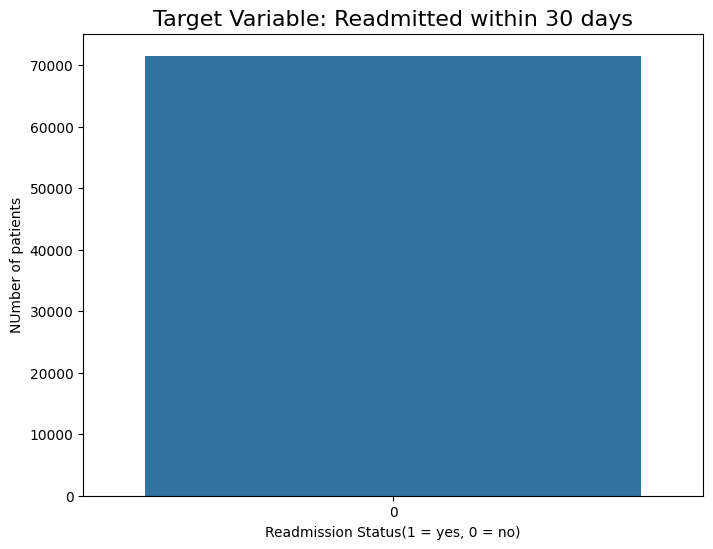

readmitted_less_than_30_days
0    1.0
Name: proportion, dtype: float64


In [17]:
#Target Variable Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted_less_than_30_days', data=df)
plt.title('Target Variable: Readmitted within 30 days', fontsize=16)
plt.ylabel('NUmber of patients')
plt.xlabel('Readmission Status(1 = yes, 0 = no)')
plt.show()
print(df['readmitted_less_than_30_days'].value_counts(normalize=True))

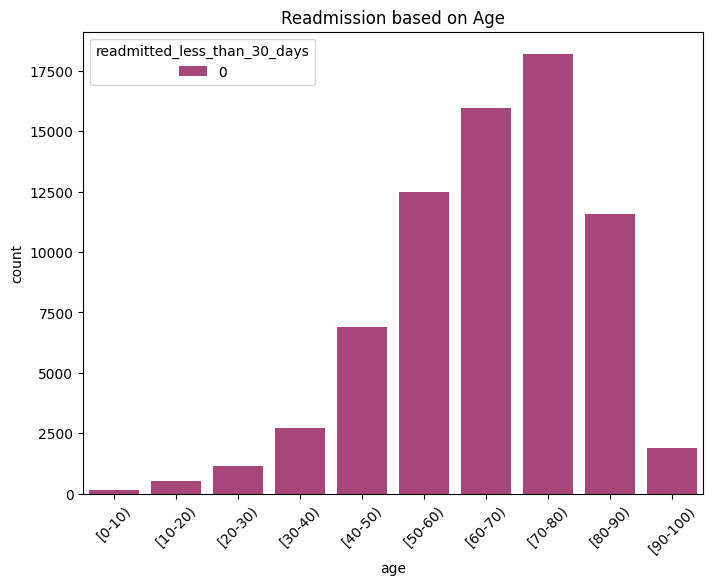

In [18]:
#Age distribution vs Readmission
plt.figure(figsize=(8,6))
sns.countplot(x='age', hue='readmitted_less_than_30_days', data=df, palette='magma')
plt.title('Readmission based on Age')
plt.xticks(rotation=45)
plt.show()

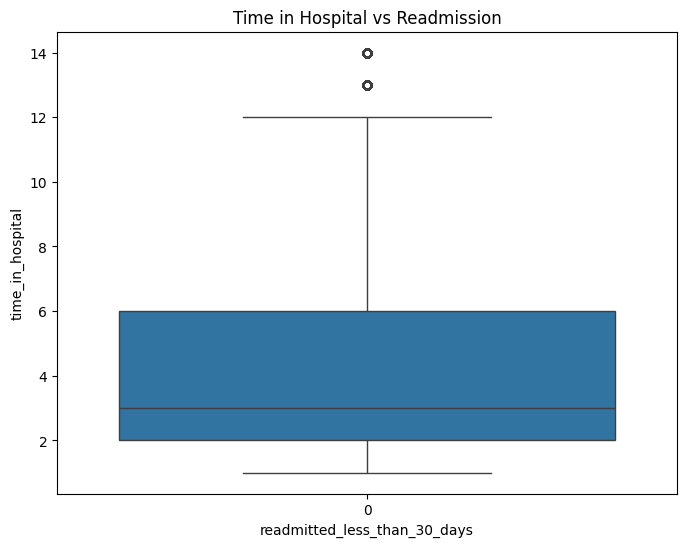

In [20]:
#Time in Hospital vs Readmission
plt.figure(figsize=(8,6))
sns.boxplot(x='readmitted_less_than_30_days', y='time_in_hospital', data=df)
plt.title('Time in Hospital vs Readmission')
plt.show()

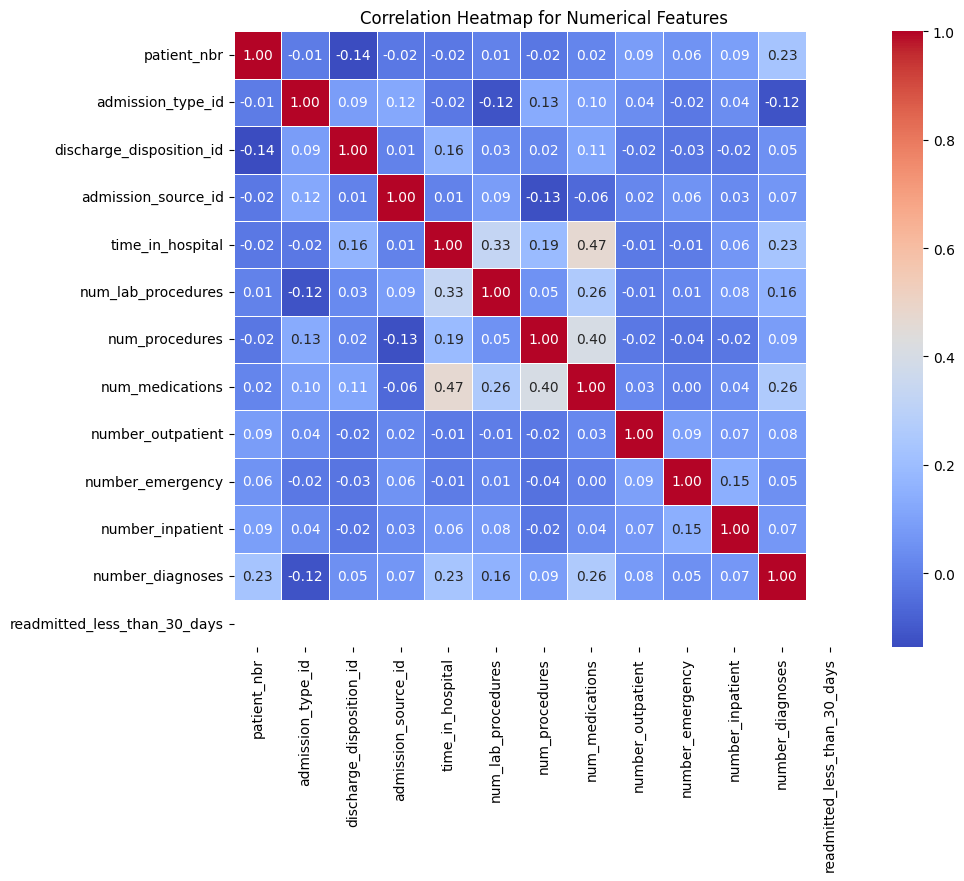

In [21]:
#Correlation Heatmap for Numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

In [22]:
#Saving cleaned data
processed_path = "/content/sample_data/cleaned_diabetic_data.csv"
df.to_csv(processed_path, index=False)